### The World Happiness Report

[World Happiness Report 2021](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021)

The World Happiness Report - это важный обзор состояния глобального счастья. Отчет продолжает получать глобальное признание, поскольку правительства, организации и гражданское общество все чаще используют индикаторы счастья для информирования своих политических решений. Ведущие эксперты в различных областях - экономика, психология, анализ опросов, национальная статистика, здравоохранение, государственная политика и др. - описывают, как измерения благосостояния могут быть эффективно использованы для оценки прогресса наций. В отчетах рассматривается состояние счастья в современном мире и показано, как новая наука о счастье объясняет личные и национальные различия в счастье.

**Содержание**

Оценки счастья и рейтинги основаны на данных всемирного опроса Gallup. Столбцы, следующие за показателем счастья, оценивают степень, в которой каждый из шести факторов - экономическое производство, социальная поддержка, ожидаемая продолжительность жизни, свобода, отсутствие коррупции и щедрость - способствует повышению оценки жизни в каждой стране.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, shapiro, mannwhitneyu, levene, ttest_ind, probplot, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
life2021 = pd.read_csv('world-happiness-report-2021.csv')
life = pd.read_csv('world-happiness-report.csv')

### Подготовка данных

Подготовка датасетов: выбор нужных столбцов, добавление данных по 2021 году к основному датасету

In [5]:
life2021 = life2021[['Country name', 'Regional indicator', 'Ladder score',
                     'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
                     'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
life2021['year'] = 2021

regions = life2021[['Country name', 'Regional indicator']]

life = life[['Country name', 'year', 'Life Ladder', 'Log GDP per capita', 
             'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 
             'Generosity', 'Perceptions of corruption']]
life = pd.merge(life, regions, on='Country name', how='inner')

life.columns = ['Country name', 'Year', 'Life Ladder', 'Logged GDP per capita',
                'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 
                'Generosity', 'Perceptions of corruption', 'Regional indicator']

life = life[['Country name', 'Regional indicator', 'Year', 'Life Ladder', 'Logged GDP per capita',
             'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
             'Perceptions of corruption']]
life2021.columns = ['Country name', 'Regional indicator', 'Life Ladder', 'Logged GDP per capita', 
                         'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 
                         'Generosity', 'Perceptions of corruption', 'Year']

life2021 = life2021[['Country name', 'Regional indicator', 'Year', 'Life Ladder', 'Logged GDP per capita',
                     'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
                     'Perceptions of corruption']]

df = life.append(life2021).sort_values(by=['Country name', 'Year']).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  2035 non-null   object 
 1   Regional indicator            2035 non-null   object 
 2   Year                          2035 non-null   int64  
 3   Life Ladder                   2035 non-null   float64
 4   Logged GDP per capita         2011 non-null   float64
 5   Social support                2026 non-null   float64
 6   Healthy life expectancy       1984 non-null   float64
 7   Freedom to make life choices  2005 non-null   float64
 8   Generosity                    1959 non-null   float64
 9   Perceptions of corruption     1931 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 159.1+ KB


In [6]:
df['Regional indicator'].value_counts()

Sub-Saharan Africa                    426
Latin America and Caribbean           299
Western Europe                        292
Central and Eastern Europe            242
Middle East and North Africa          228
Commonwealth of Independent States    182
Southeast Asia                        125
South Asia                             91
East Asia                              88
North America and ANZ                  62
Name: Regional indicator, dtype: int64

### __а)__ EDA 

(рассчитать описательные статистики (мю,сигма,квартили…)+ графический анализ с выводами). 

Рассмотрим распределение показателя счастья по всем странам в 2020 году.

In [7]:
year_20 = df['Year'] == 2020
world_2020 = df.loc[year_20].sort_values('Life Ladder')

year_21 = df['Year'] == 2021
world_2021 = df.loc[year_21].sort_values('Life Ladder')

year_19 = df['Year'] == 2019
world_2019 = df.loc[year_19].sort_values('Life Ladder')

In [8]:
mu = world_2020['Life Ladder'].mean()
sigma = world_2020['Life Ladder'].std(ddof=1)

quantile_1 = world_2020['Life Ladder'].quantile(0.25)
quantile_3 = world_2020['Life Ladder'].quantile(0.75)
median = world_2020['Life Ladder'].median()
rus = world_2020['Life Ladder'].loc[world_2020['Country name'] == 'Russia']
fr = world_2020['Life Ladder'].loc[world_2020['Country name'] == 'France']

print(f'mu: {mu:.2f}',
      f'standart deviation: {sigma:.2f}',
      f'1st quantile: {quantile_1:.2f}', 
      f'3rd quantile: {quantile_3:.2f}',
      f'median: {median:.2f}', sep='\n')

mu: 5.84
standart deviation: 0.98
1st quantile: 5.20
3rd quantile: 6.50
median: 5.88


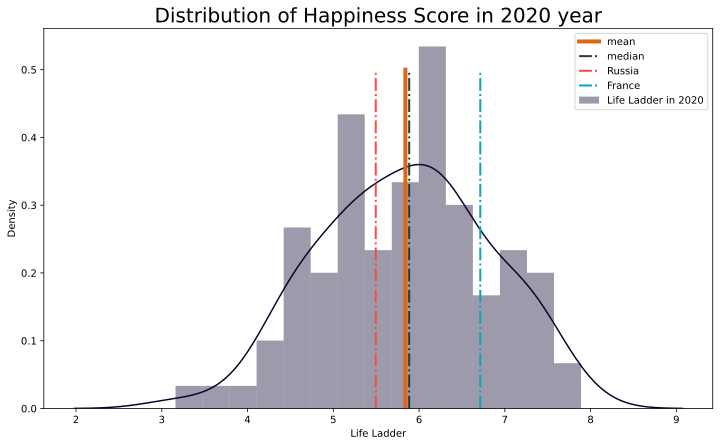

In [9]:
y = np.linspace(0, 0.5, 30)
plt.figure(figsize = (12, 7))

plt.title('Distribution of Happiness Score in 2020 year', size=20)
sns.distplot(world_2020['Life Ladder'], bins=15, label='Life Ladder in 2020', color='#0B032D')

plt.plot([mu] * 30, y, label='mean', linestyle='solid', linewidth=4, color='#e36414')
plt.plot([median] * 30, y, label='median', linestyle='-.', linewidth=2, color='#273C2C')
plt.plot([rus] * 30, y, label='Russia', linestyle='dashdot', linewidth=2, color='#F44E3F')
plt.plot([fr] * 30, y, label='France', linestyle='dashdot', linewidth=2, color='#08A4BD')
plt.legend()
plt.show()

На графике выше отражена гистограмма и раcпределение показателя счастья во всему миру со средним значением и медианой. Среднее значение отличается от медианы в меньшую сторону, следовательно есть страны с очень низким показателем счастья. Дополнительно на графике обозначены показатели двух стран: Россия и Франция. Россия (обозначена голубым) находится  ниже среднего показателя, Франция (обозначена красным) - выше.  

Теперь сравним распределение с нормальным.

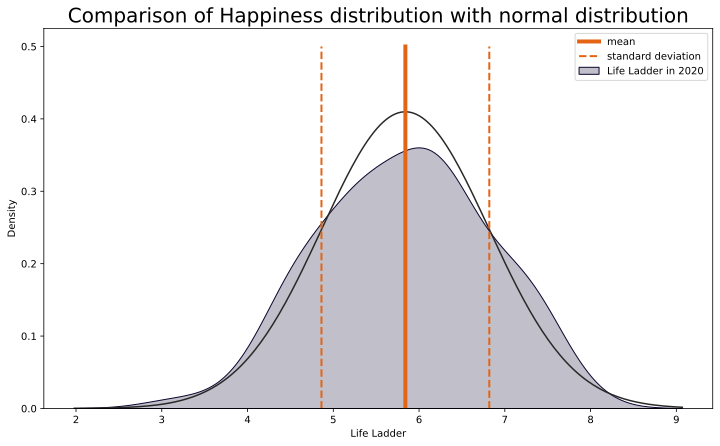

In [10]:
plt.figure(figsize = (12, 7))
plt.title('Comparison of Happiness distribution with normal distribution', size=20)
sns.distplot(world_2020['Life Ladder'], kde_kws={"shade": True}, fit=norm, hist=False, label='Life Ladder in 2020', color='#0B032D')
plt.plot([mu] * 30, y, label='mean', linestyle='solid', linewidth=4, color='#e36414')
plt.plot(([mu + sigma] * 30), y, label='standard deviation', linestyle='--', linewidth=2, color='#e36414')
plt.plot(([mu - sigma] * 30), y, linestyle='--', linewidth=2, color='#e36414')
plt.legend()
plt.show()

Видно, что распределение близко к нормальному, проверим эту гипотезу. 

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

**Гипотеза** 
* $H_0$: Распределение соответствует нормальному распределению
* $H_1$: Распределение отлично от нормального
* Критерий: критерия Шапиро-Уилка
* Уровень значимости $\normalsize \alpha$: 0.05

In [11]:
shapiro(world_2020['Life Ladder'])

ShapiroResult(statistic=0.988757848739624, pvalue=0.6023191213607788)

P-value бользе заданного уровня значимости, следовательно, верна нулевая гипотеза, распределение соответствует нормальному.  
Посмотрим статистики всех числовых признаков:

In [12]:
df.describe()

,Year,Life Ladder,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,2035.000000,2035.000000,2011.000000,2026.000000,1984.000000,2005.000000,1959.000000,1931.000000
mean,2013.826536,5.490948,9.391096,0.814959,63.695212,0.748269,-0.002346,0.746277
std,4.514250,1.107523,1.141129,0.116125,7.376080,0.139289,0.162257,0.186760
min,2005.000000,2.375000,6.635000,0.291000,32.300000,0.258000,-0.335000,0.035000
25%,2010.000000,4.669000,8.484000,0.751000,59.180000,0.656000,-0.117000,0.690000
50%,2014.000000,5.420000,9.487000,0.836000,65.400000,0.769000,-0.029000,0.801000
75%,2018.000000,6.298000,10.370500,0.906750,68.800000,0.861000,0.089000,0.870000
max,2021.000000,8.019000,11.648000,0.987000,77.100000,0.985000,0.698000,0.983000


В данных есть пропущенные сначения. Медианы и средние значения практически у всех значений близкие по значению, выбросов не очень много. Посмотрим на уровень счаcтья в каждом регионе, используя график boxplot

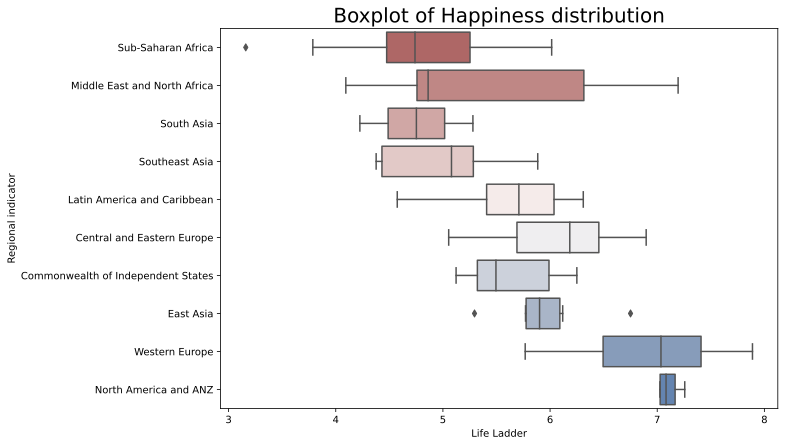

In [13]:
plt.figure(figsize = (10, 7))
plt.title('Boxplot of Happiness distribution', size=20)
sns.boxplot(world_2020['Life Ladder'], world_2020['Regional indicator'], orient='h', palette='vlag_r')

plt.show()

В каждой группе стран значения отличаются. Есть регионы, в который большой разброс значений, например, страны Африки (низкий показатель счастья), страны Западной Европы (высокий показатель счастья)

Посчитаем все средние значения по годам. На основе этих данных построим графики изменения признаков за последние 10 лет. 

In [14]:
mean_table = df.groupby('Year')[df.columns].mean()
mean_table

,Year,Life Ladder,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Year,,,,,,,,
2005,2005,6.446259,10.118667,0.897407,67.007407,0.829520,0.256000,0.715880
2006,2006,5.187057,9.030724,0.833678,60.032326,0.734524,0.004975,0.753780
2007,2007,5.414747,9.201909,0.809526,61.551755,0.687337,0.013020,0.792021
2008,2008,5.411290,9.171421,0.785262,61.292905,0.686365,0.018906,0.764865
2009,2009,5.485565,9.295731,0.816766,62.651896,0.685991,-0.009111,0.773257
2010,2010,5.530703,9.425551,0.833819,63.358207,0.708026,0.003712,0.760684
2011,2011,5.444971,9.314088,0.808949,62.572947,0.732289,-0.016726,0.757208
2012,2012,5.469356,9.408060,0.811422,63.452700,0.715119,-0.003528,0.760675
2013,2013,5.425727,9.397489,0.808023,63.563453,0.732763,-0.004961,0.760896


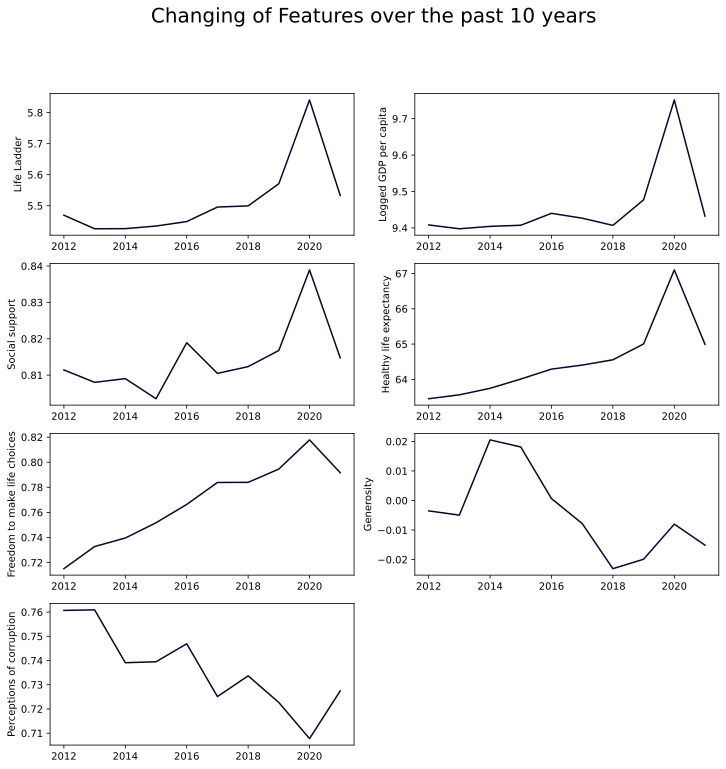

In [15]:
mean_table10 = mean_table.loc[mean_table['Year']>2011]
fig=plt.figure(figsize=(12, 12))
plt.suptitle("Changing of Features over the past 10 years", size=20)
i=0
for column in mean_table.columns[1:]:
    
    ax=plt.subplot(421+i)
    ax = plt.plot(mean_table10['Year'], mean_table10[column], color='#0B032D')
    ax = plt.ylabel(column)
    i+=1  

Видно, что за последние годы, до 2020 года положительные показатели такие, как ВВП, свобода выбора, социальная поддержка значительно выросли, а отрицательные (восприятие коррупции) уменьшились, что в среднем, способствует увеличению "счастливого" балла.  
Также можно наблюдать резкий спад положительных показателей и рост отрицательных в 2021 году. Возможно, это связано с пандемией, либо недостаточно данных для оценки года в целом

Для того, чтобы посмотреть на значения по всем странам и увидеть экстремальные значения, построим столбчатую диаграмму, на которой красные значения - минимальные, синие - максимальные

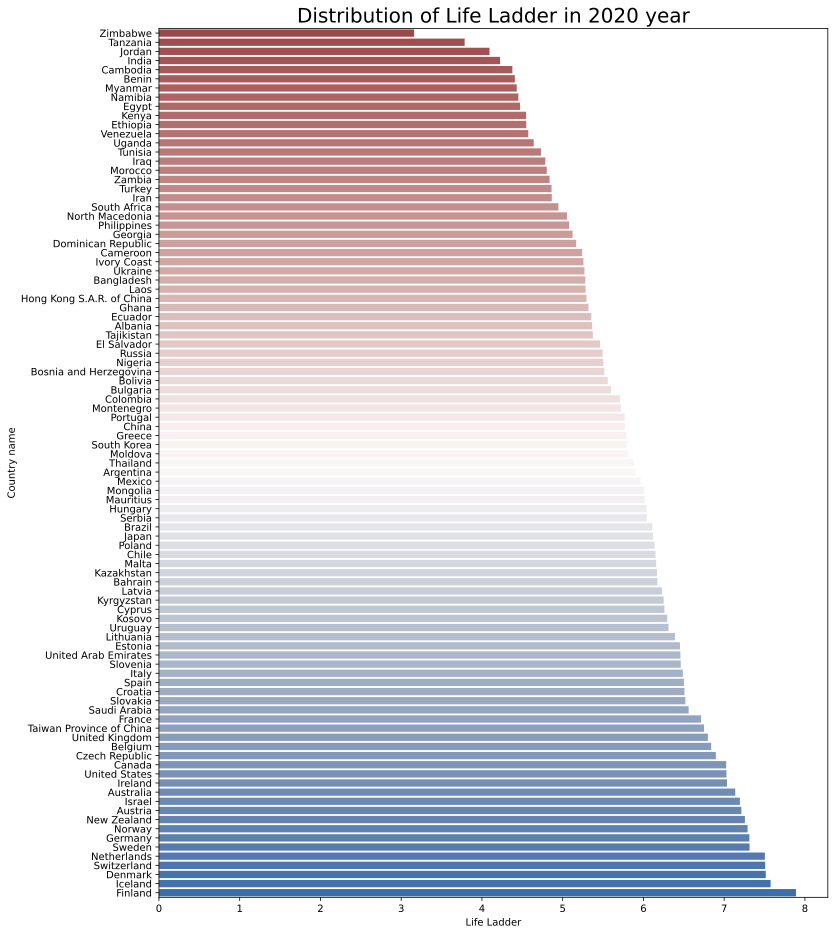

In [16]:
plt.figure(figsize = (12, 16))
condition = world_2020['Life Ladder']

sns.barplot(world_2020['Life Ladder'], world_2020['Country name'], 
            label='Life Ladder in 2020', palette='vlag_r')
plt.title('Distribution of Life Ladder in 2020 year', size=20)
plt.show()
# plt.savefig('life_ladder.jpg')

По диаграмме видно что самый низкий показатель у Танзании, Зимбабве и Иордании, самый высокий показатель у Финляндии, Исландии и Дании, там живут самые счастливые люди. 

Посмотрим на распределение значений по странам - Россия, США и Франция

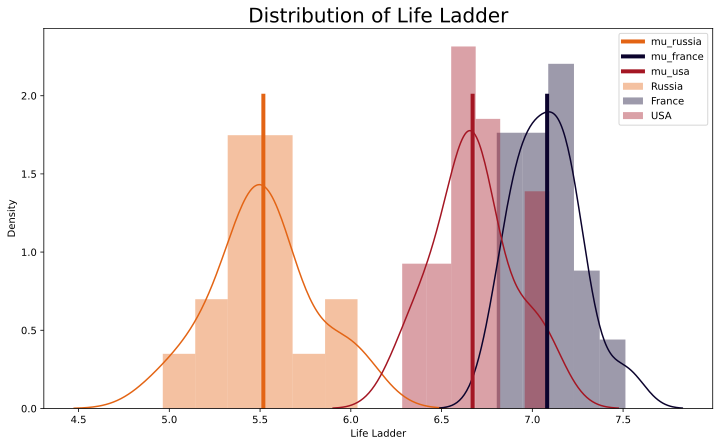

In [17]:
russia = df.loc[df['Country name']=='Russia', 'Life Ladder']
france = df.loc[df['Country name']=='France', 'Life Ladder']
usa = df.loc[df['Country name']=='United States', 'Life Ladder']

plt.figure(figsize = (12, 7))

sns.distplot(russia, label='Russia', color='#e36414')
sns.distplot(usa, label='France', color='#0B032D')
sns.distplot(france, label='USA', color='#A41623')

y = np.linspace(0, 2, 10)
plt.plot([russia.mean()] * 10, y, label='mu_russia',  linewidth=4, color='#e36414')
plt.plot([usa.mean()] * 10, y, label='mu_france',  linewidth=4, color='#0B032D')
plt.plot([france.mean()] * 10, y, label='mu_usa', linewidth=4, color='#A41623')

plt.title('Distribution of Life Ladder', size=20)
plt.legend()
plt.show()

В России уровень счастья оказался этот ниже, чем во Франции и США (неожиданно :) )

### __б)__ Тестирование гипотезы 

(условия применимости того или иного критерия проверить , можно с графиками+ провести тестирование, оформить вывод). 

Посмотрим на наспределение уровня счастья по годам (последние 5 лет):

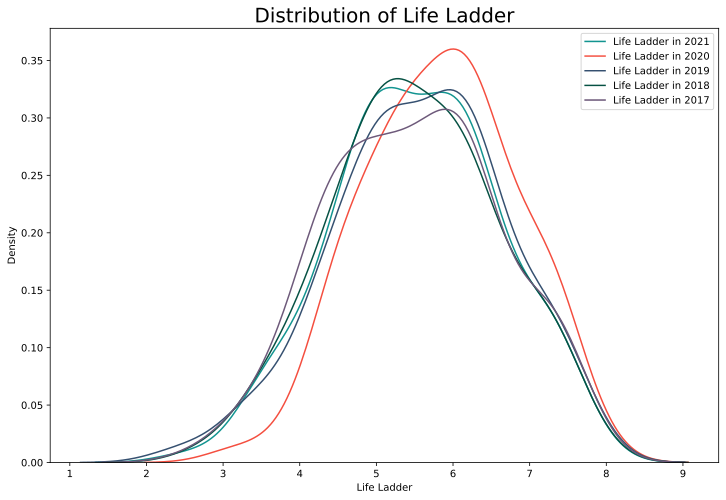

In [18]:
life_in_west_eu_2020 = df.loc[ (df['Year'] == 2020) & (df['Regional indicator'] == 'Western Europe'), 'Life Ladder'] 
cond = df.loc[(df['Year'] == 2021) & (df['Life Ladder'] > 6.5), 'Life Ladder']
world21 = df.loc[(df['Year'] == 2021) , 'Life Ladder']
world20 = df.loc[(df['Year'] == 2020), 'Life Ladder']
world19 = df.loc[(df['Year'] == 2019), 'Life Ladder']
world18 = df.loc[(df['Year'] == 2018), 'Life Ladder']
world17 = df.loc[(df['Year'] == 2017), 'Life Ladder']
plt.figure(figsize = (12, 8))

sns.distplot(world21, label='Life Ladder in 2021', hist=False, color='#129490')
sns.distplot(world20, label='Life Ladder in 2020', hist=False, color='#f44e3f')
sns.distplot(world19, label='Life Ladder in 2019', hist=False, color='#355070')
sns.distplot(world18, label='Life Ladder in 2018', hist=False, color='#065143')
sns.distplot(world17, label='Life Ladder in 2017', hist=False, color='#6d597a')
plt.title('Distribution of Life Ladder', size=20)

plt.legend()
plt.show()

По графику видно, что за последние 5 лет 2020 год в среднем выделяется на фоне всех остальных. Проверим это с помощью t-критерия Стьюдента.  

Условия применения t-критерия Стьюдента:

   * Распределение признаков в каждой выборке соответствует нормальному распределению
   * Дисперсии признака в выборках примерно равны
   
Сначала проверим, является ли распределение нормальным
   

*Проверка распределения выборок на "нормальность" с помощью критерия Шапиро-Уилка*

**Гипотеза** 
* $H_0$: Распределение соответствует нормальному распределению
* $H_1$: Распределение отлично от нормального
* Критерий: критерия Шапиро-Уилка
* Уровень значимости $\normalsize \alpha$: 0.05

In [19]:
num = 2017, 2018, 2019, 2020, 2021
years = world17, world18, world19, world20, world21

for i in range(len(years)):
    stat, pvalue = shapiro(years[i])
    print(f'{num[i]}: ', 'Normal Distribution' if pvalue > 0.05 else 'Not')

2017:  Normal Distribution
2018:  Normal Distribution
2019:  Normal Distribution
2020:  Normal Distribution
2021:  Normal Distribution


*Проверка гипотезы о равенстве дисперсий выборок:*

**Гипотеза** 
* $H_0$: $\sigma_1^2 = \sigma_2^2 = \sigma_3^2$ 
* $H_1$: $\sigma_1^2 \neq \sigma_2^2 \neq \sigma_3^2$
* Критерий: тест Левена
* Уровень значимости $\normalsize \alpha$: 0.05

In [20]:
levene(*years)

LeveneResult(statistic=0.6374410556832774, pvalue=0.635934193396148)

Так как значения pvalue выше уровня значимости $\normalsize \alpha$, верна нулевая гипотеза - Дисперсии выборок примерно равны.  
Теперь сравним между собой показатели счастья за несколько лет

*Проверка гипотезы о равенстве двух средних значений:*

**Гипотеза** 
* $H_0$: $\mu_1 = \mu_2$ 
* $H_1$: $\mu_1 \neq \mu_2$
* Критерий: односторонний t-критерий Стьюдента
* Уровень значимости $\normalsize \alpha$: 0.05

In [21]:
print(f'2017 - 2018: {ttest_ind(world17, world18)}',
      f'2018 - 2019: {ttest_ind(world18, world19)}',
      f'2019 - 2020: {ttest_ind(world19, world20)}',
      f'2018 - 2020: {ttest_ind(world18, world20)}',
      f'2020 - 2021: {ttest_ind(world20, world21)}', 
      f'2019 - 2021: {ttest_ind(world19, world21)}', sep='\n')

2017 - 2018: Ttest_indResult(statistic=-0.0287801086694074, pvalue=0.9770602501945035)
2018 - 2019: Ttest_indResult(statistic=-0.5501000184307456, pvalue=0.5826831465991602)
2019 - 2020: Ttest_indResult(statistic=-1.9233494954002757, pvalue=0.05563425000221229)
2018 - 2020: Ttest_indResult(statistic=-2.4682147643708543, pvalue=0.014292082791933673)
2020 - 2021: Ttest_indResult(statistic=2.258402384397067, pvalue=0.024811744193226768)
2019 - 2021: Ttest_indResult(statistic=0.2978145290319295, pvalue=0.7660572344885922)


Исходя из полученной статистики, в 2020 году средний показатель счастья был выше, чем остальные пять лет (интересно, почему?)

Сравним между собой показатели счастья по регионам европы и странам СНГ в 2021 году. Для этого сначала посмотрим на  их плотность распределения

1 Выборка  - Central and Eastern Europe,  
2 Выборка - Commonwealth of Independent States,  
3 Выборка - Western Europe

In [22]:
regions = df['Regional indicator'].unique()
reg = ['Central and Eastern Europe', 'Commonwealth of Independent States', 'Western Europe']

europe_east_score = df.loc[(df['Regional indicator']==reg[0])&year_21, 'Life Ladder']
cis_score = df.loc[(df['Regional indicator']==reg[1])&year_21, 'Life Ladder']
europe_west_score = df.loc[(df['Regional indicator']==reg[2])&year_21, 'Life Ladder']

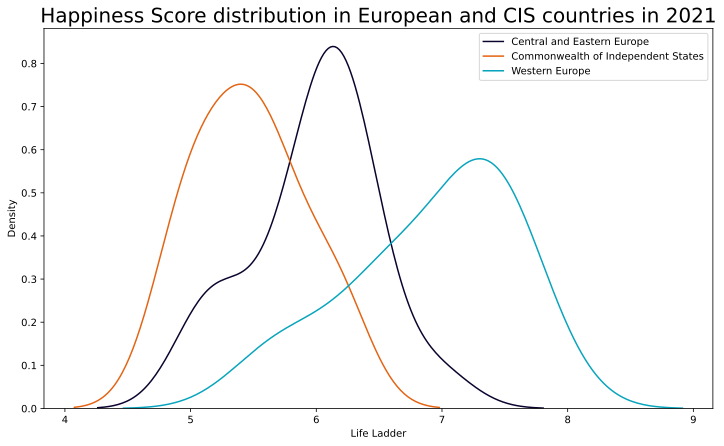

In [23]:
plt.figure(figsize = (12, 7))
plt.title('Happiness Score distribution in European and CIS countries in 2021', size=20)

sns.distplot(europe_east_score, label=reg[0], hist=False, color='#0B032D')
sns.distplot(cis_score, label=reg[1], hist=False, color='#e36414')
sns.distplot(europe_west_score, label=reg[2], hist=False, color='#08A4BD')

plt.legend()
plt.show()

По графикам видно, что в среднем люди более счастливы в Западной европе, затем по убывающей идут значения Восточной Европы и стран СНГ. Проверим, являются ли эти различия статистически значимыми.  

Для сравнения выборок будем использовать t-критерий Стьюдента, так как в наших независимых выборках небольшое число наблюдений и неизвестно стандартное отклонение генеральной совокупности.

Проверим условия применения t-критерия Стьюдента

*QQ-график*

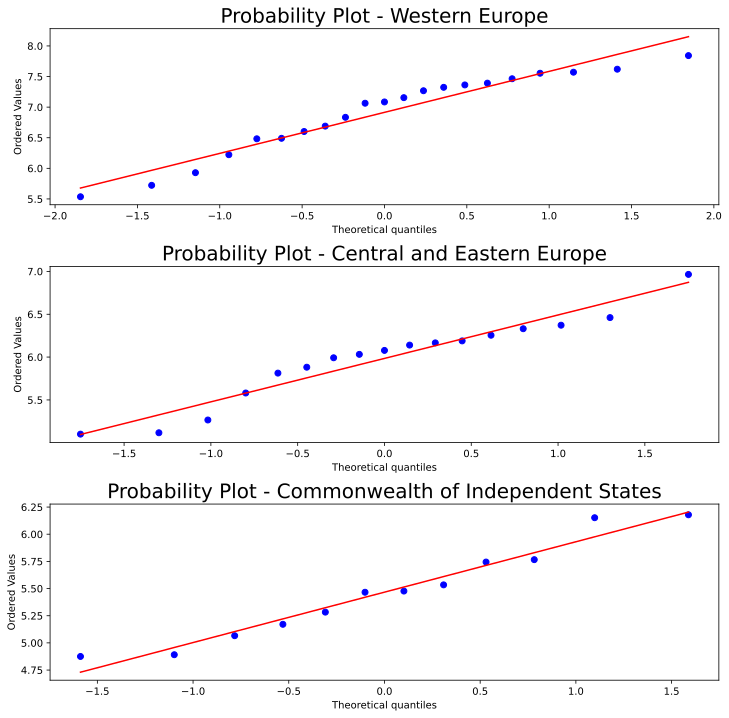

In [24]:
fig = plt.figure(figsize=[12, 12], dpi=100)
plt.subplots_adjust(hspace=0.35)

ax1 = fig.add_subplot(311)
probplot(europe_west_score, dist="norm", plot=plt)
ax1.set_title("Probability Plot - Western Europe", size=20)

ax2 = fig.add_subplot(312)
probplot(europe_east_score, dist="norm", plot=plt)
ax2.set_title("Probability Plot - Central and Eastern Europe", size=20)

ax3 = fig.add_subplot(313)
probplot(cis_score, dist="norm", plot=plt)
ax3.set_title("Probability Plot - Commonwealth of Independent States", size=20)
plt.show()

*Проверка распределения выборок на "нормальность" с помощью критерия Шапиро-Уилка*

**Гипотеза** 
* $H_0$: Распределение соответствует нормальному распределению
* $H_1$: Распределение отлично от нормального
* Критерий: критерия Шапиро-Уилка
* Уровень значимости $\normalsize \alpha$: 0.05

In [25]:
for region in reg:
    region_score = df.loc[(df['Regional indicator']==region)&year_21, 'Life Ladder']
    print(f'{region}: \n{shapiro(region_score)}\n', )

Central and Eastern Europe: 
ShapiroResult(statistic=0.94045090675354, pvalue=0.3235708475112915)

Commonwealth of Independent States: 
ShapiroResult(statistic=0.9442336559295654, pvalue=0.5547783374786377)

Western Europe: 
ShapiroResult(statistic=0.9320827722549438, pvalue=0.15153758227825165)



Так как значения pvalue у каждой выборки выше допустимого уровня значимости $\normalsize \alpha$, верна нулевая гипотеза - Распределения соответствуют нормальному.

*Проверка гипотезы о равенстве дисперсий выборок:*

1 Выборка  - Central and Eastern Europe,  
2 Выборка - Commonwealth of Independent States,  
3 выборка - Western Europe 

**Гипотеза** 
* $H_0$: $\sigma_1^2 = \sigma_2^2 = \sigma_3^2$ 
* $H_1$: $\sigma_1^2 \neq \sigma_2^2 \neq \sigma_3^2$
* Критерий: тест Левена
* Уровень значимости $\normalsize \alpha$: 0.05

In [26]:
levene(europe_east_score, cis_score, europe_west_score)

LeveneResult(statistic=1.393128897914909, pvalue=0.258360905098615)

Так как значения pvalue выше уровня значимости $\normalsize \alpha$, верна нулевая гипотеза - Дисперсии выборок примерно равны.  
Теперь попарно сравним между собой показатели счастья в трех регионах

*Проверка гипотезы о равенстве двух средних значений:*

1 Выборка  - Central and Eastern Europe,  
2 Выборка - Commonwealth of Independent States,  

**Гипотеза** 
* $H_0$: $\mu_1 = \mu_2$ 
* $H_1$: $\mu_1 > \mu_2$
* Критерий: односторонний t-критерий Стьюдента
* Уровень значимости $\normalsize \alpha$: 0.05

In [27]:
ttest_ind(europe_east_score, cis_score)

Ttest_indResult(statistic=2.911805045951379, pvalue=0.007124317773895843)

P-value ниже уровня значимости, следовательно, отвергается нулевая Гипотеза и принимается альтернативная о том, что В странах Средней и восточной европы в среднем люди более счастливы, чем в странах СНГ.  
Теперь сравним другие две выборки - Значения по Западной Европе и значения по Средней и Восточной Европе:

*Проверка гипотезы о равенстве двух средних значений:*

1 Выборка - Central and Eastern Europe,  
3 Выборка - Western Europe 

**Гипотеза** 
* $H_0$: $\mu_1 = \mu_3$ 
* $H_1$: $\mu_1 < \mu_3$
* Критерий: односторонний t-критерий Стьюдента
* Уровень значимости $\normalsize \alpha$: 0.05

In [28]:
ttest_ind(europe_east_score, europe_west_score)

Ttest_indResult(statistic=-4.835474114084431, pvalue=2.481309186107338e-05)

P-value существенно ниже уровня значимости, следовательно, снова отвергается нулевая Гипотеза и принимается альтернативная о том, что В странах Западной Европы в среднем люди более счастливы, чем в странах Средней и Восточной европы. 

Чтобы окончательно убедиться в различиях всех трех выборок, сравним между собой значения по Западной Европе и по странам СНГ:

*Проверка гипотезы о равенстве двух средних значений:*

2 Выборка - Commonwealth of Independent States,  
3 Выборка - Western Europe 

**Гипотеза** 
* $H_0$: $\mu_2 = \mu_3$ 
* $H_1$: $\mu_2 < \mu_3$
* Критерий: односторонний t-критерий Стьюдента
* Уровень значимости $\normalsize \alpha$: 0.05

In [29]:
ttest_ind(cis_score, europe_west_score)

Ttest_indResult(statistic=-6.800310019954693, pvalue=1.287975614645956e-07)

Все три выборки имеют статистически значимые различия, гипотеза о том, что в Западной Европе люди счастливее, чем в Восточной, а у последних показатель выше, чем в СНГ - верна.

### __в)__ Линейная регрессия

(условия применимости метода проверить ,можно с графиками, построить модель, исследовать на статистическую значимость модель ,можно и коэффициенты (самостоятельное изучение), коэффициент детерминации.     

Посмотрим, какие факторы влияют на уровень счастья жителей всего мира.  
Для того, чтобы проследить наличие линейной зависимости величины Life Ladder c другими признаками, построим таблицу корреляций

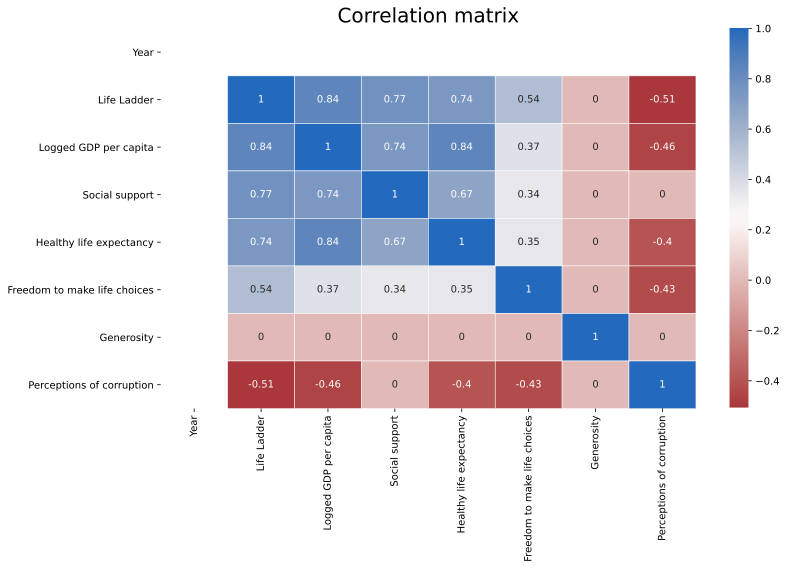

In [30]:
matrix = world_2020.corr().round(decimals=2)
matrix[np.abs(matrix) < 0.3] = 0

plt.figure(figsize = (12, 7))
plt.title('Correlation matrix', size=20)
sns.heatmap(matrix, annot=True, vmax=True, linewidths=.5, cmap='vlag_r')
plt.plot()
plt.show()

Видно, что наблюдается сильная линейная связь целевой переменной с Logged GDP per capita (ВВП на душу населения), Social Support (Социальная поддержка), Freedom to make life choice (Свобода выбора), Healthy life expectancy (Средняя продолжительность здоровой жизни). Кроме того, есть обратная линейная связь Perceptions of corruption (Уровень коррупции).

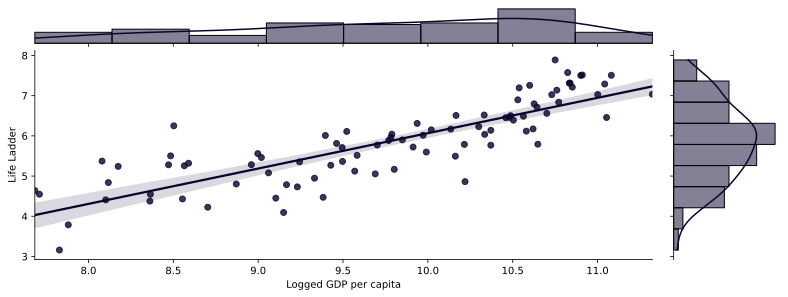

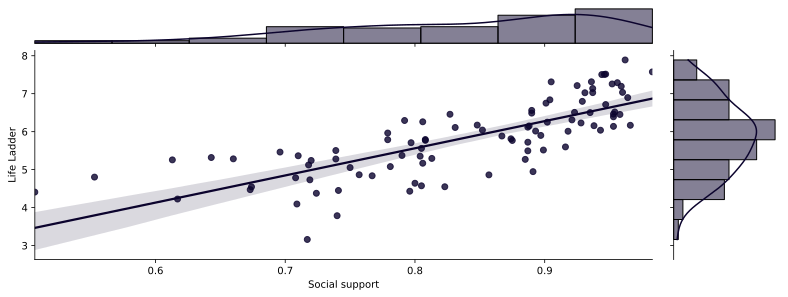

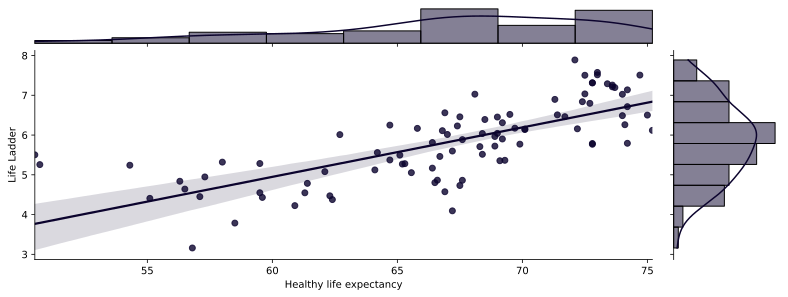

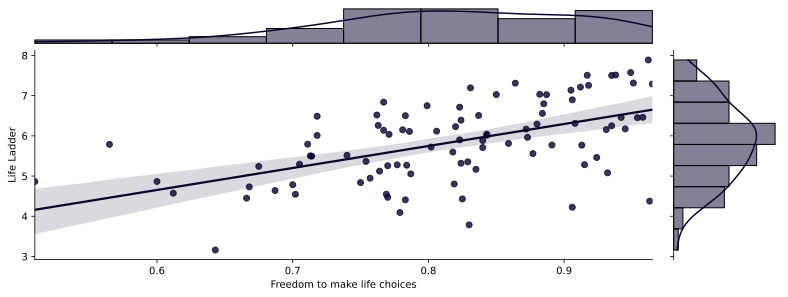

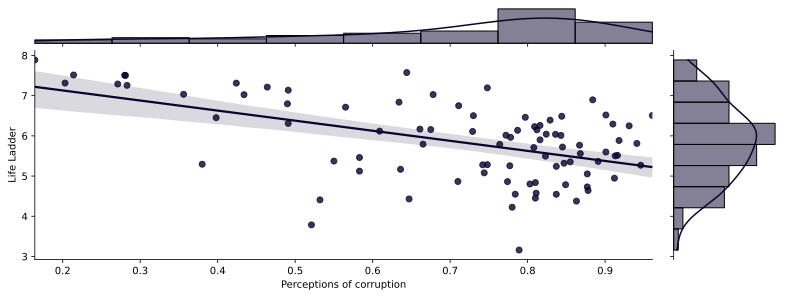

In [31]:
features = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
            'Freedom to make life choices', 'Perceptions of corruption']
y = 'Life Ladder'

# fig=plt.figure(figsize=(8,8))
# plt.suptitle("", size=20)
j=0
features_dis = []
for x in features:
    features_dis.append(world_2020[x])
    grid = sns.jointplot(world_2020[x], world_2020[y], color='#0B032D', kind='reg')
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(4)
#     ax = plt.ylabel(y)
#     ax = plt.xlabel(x)
    j=j+1  
plt.show()

Видно, что дисперсии однородны, есть линейная связь между x и y. Построим математическую модель линейной регрессии вида
$$y = \alpha + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + ... + \beta_n \cdot x_n$$
И найдем коэффициенты при $x$
 
Для построения модели линейной регресси заполним пустоты медианой:

In [32]:
medians = world_2020.median()
medians['Life Ladder']

for col in world_2020.columns[2:]:
    world_2020[col].fillna(medians[col], inplace=True)
    
world_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 2033 to 576
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  95 non-null     object 
 1   Regional indicator            95 non-null     object 
 2   Year                          95 non-null     int64  
 3   Life Ladder                   95 non-null     float64
 4   Logged GDP per capita         95 non-null     float64
 5   Social support                95 non-null     float64
 6   Healthy life expectancy       95 non-null     float64
 7   Freedom to make life choices  95 non-null     float64
 8   Generosity                    95 non-null     float64
 9   Perceptions of corruption     95 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 10.2+ KB


Построим модель линейной регрессии и выведем значения коэффициентов

In [33]:
model = LinearRegression()
model.fit(world_2020[features], world_2020[y])

model.intercept_, model.coef_

(-3.0392503407256948,
 array([ 0.4676351 ,  2.96007663,  0.00499788,  2.33223686, -0.57671717]))

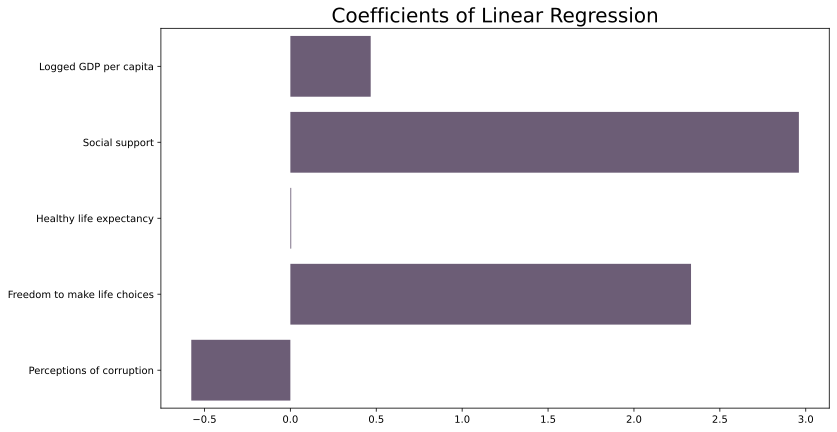

In [34]:
plt.figure(figsize = (12, 7))

sns.barplot(model.coef_.flatten(), features, color='#6D597A')
plt.title('Coefficients of Linear Regression', size=20)
plt.show()

Средняя квадратичная ошибка MSE и коэффициент детерминации для первой модели:

In [35]:
y_pred = model.predict(world_2020[features])
print(f'MSE: {mean_squared_error(world_2020[y], y_pred):.4f}',
      f'R2: {r2_score(world_2020[y], y_pred):.2f}', sep='\n')

MSE: 0.1813
R2: 0.81


Посмотрим на значения коэффициентов для каждого признака:

Самый большой вклад в построение линейной модели вносит признак Social Support, самый маленький - Healthy life expectancy. 

*Оценка статистической значимости коэффициентов регрессии*

Теперь мы должны проверить статистическую значимость коэффициентов. Для этого установим проверим гипотезу о влиянии коэффициентов на целевую переменную. Нулевая гипотеза состоит в том, что коэффициент не влияет на целевую переменную

**Гипотеза** 
* $H_0$: $\beta_i = 0$ 
* $H_1$: $\beta_i \neq 0$
* Критерий: F-критерий Фишера
* Уровень значимости $\normalsize \alpha$: 0.05

Воспользуемся библиотекой statmodels для проверки гипотезы для всех коэффициентов

In [36]:
X = world_2020[features]
X = sm.add_constant(X)
Y = world_2020['Life Ladder']
est = sm.OLS(Y, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     75.25
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           1.85e-30
Time:                        21:38:41   Log-Likelihood:                -53.680
No. Observations:                  95   AIC:                             119.4
Df Residuals:                      89   BIC:                             134.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Видно, что p-value у коэффициента, отвечающего за признак Healthy life expectancy превышает уровень статистической значимости $\normalsize \alpha$, следовательно, он не является статистически значимым, его можно не использовать для модели регрессии. Переобучим модель

In [37]:
features_new = ['Logged GDP per capita', 'Social support', 'Freedom to make life choices', 
            'Perceptions of corruption']
model2 = LinearRegression()
model2.fit(world_2020[features_new], world_2020[y])

model2.intercept_, model2.coef_

(-2.9633773026258714,
 array([ 0.49057122,  2.98913973,  2.34884159, -0.57985939]))

In [38]:
y_pred_2 = model2.predict(world_2020[features_new])
print(f'MSE: {mean_squared_error(world_2020[y], y_pred_2):.4f}',
      f'R2: {r2_score(world_2020[y], y_pred_2):.2f}', sep='\n')

MSE: 0.1815
R2: 0.81


*Проверка распределения отклонений на соответствие нормальному*

In [39]:
err = (world_2020[y] - y_pred_2)

**Гипотеза** 
* $H_0$: Распределение отклонений соответствует нормальному распределению
* $H_1$: Распределение отлично от нормального
* Критерий: критерия Шапиро-Уилка
* Уровень значимости $\normalsize \alpha$: 0.05

In [40]:
shapiro(err)

ShapiroResult(statistic=0.9919975996017456, pvalue=0.8440686464309692)

Значение значительно превышает уровень значимости, из этого следует, что распределения отклонений соответствует нормальному распределению. Убидимся в этом с помощью QQ-графика

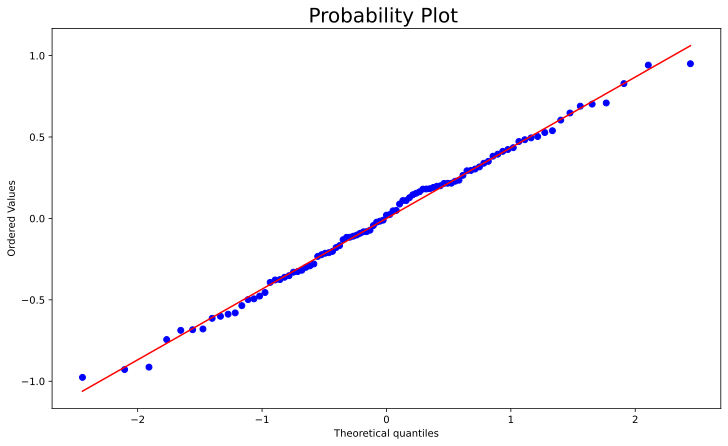

In [41]:
fig = plt.figure(figsize=[12, 7], dpi=100)
probplot(err, dist="norm", plot=plt)
plt.title("Probability Plot ", size=20)
plt.show()

Все значения отклонений результата регрессии от истинных значений лежат на прямой, соответственно, распределение соответствует нормальному.
Из этого делаем вывод, что подобранная линейная модель хорошо описывает данные. Уравнение линейной регрессии:

$$y = -2.96 + 0.49 x_1 + 2.99 x_2 +  2.35 x_3 -0.58 x_4$$

Где $y$ - Показатель Life Ladder, а признаки:

* $x_1$ - Logged GDP per capita,  
* $x_2$ - Social support, 
* $x_3$ - Freedom to make life choices,  
* $x_4$ - Perceptions of corruption

### __г)__ Однофакторный или двухфакторный дисперсионный анализ  

(обязательно условия применимости исследовать, провести анализ, оформить вывод).  

Посмотрим, отличаются ли значения Generosity в зависимости от региона (2021 год)

Условия применимости данной модели дисперсионного анализа:  

* нормальность распределения данных для каждого уровня фактора;  
* однородность (равенство) дисперсий для различных уровней фактора.
* независимость

Так как это данные разных регионов мира - они не зависят друг от друга.  
Проверим данные на нормальное распределение с помощью QQ-графика

*QQ-график*

South Asia variance = 0.01


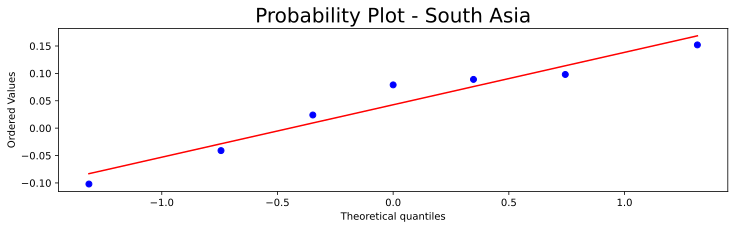

Central and Eastern Europe variance = 0.02


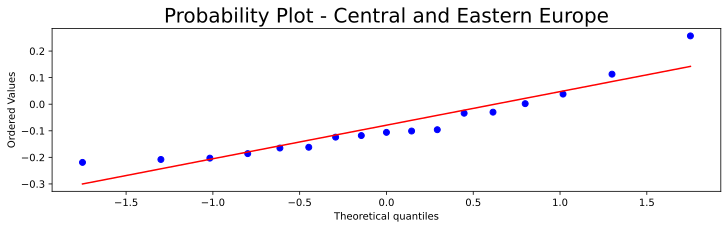

Middle East and North Africa variance = 0.01


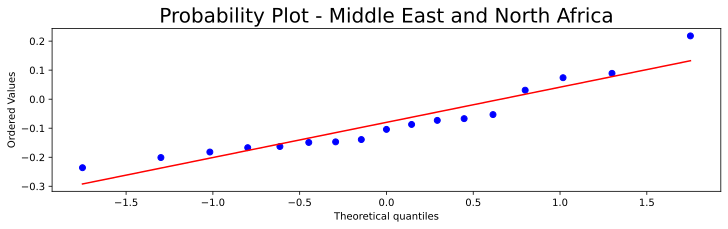

Latin America and Caribbean variance = 0.02


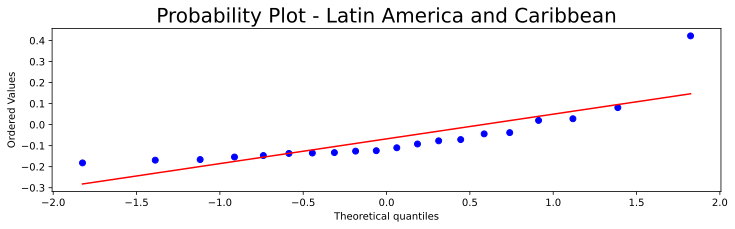

Commonwealth of Independent States variance = 0.03


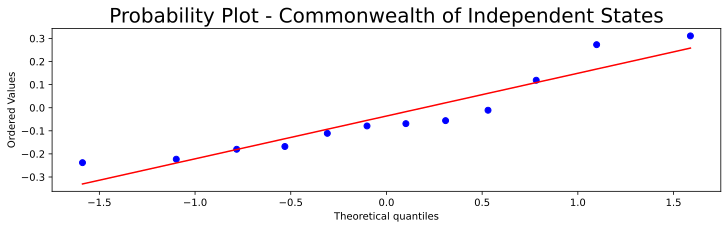

North America and ANZ variance = 0.00


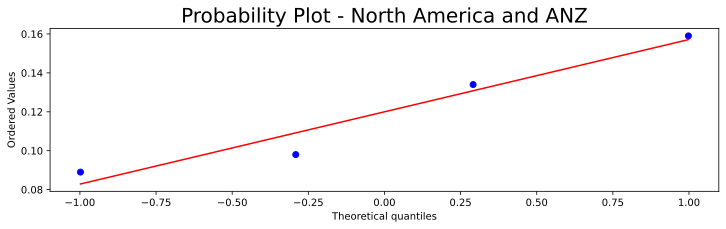

Western Europe variance = 0.02


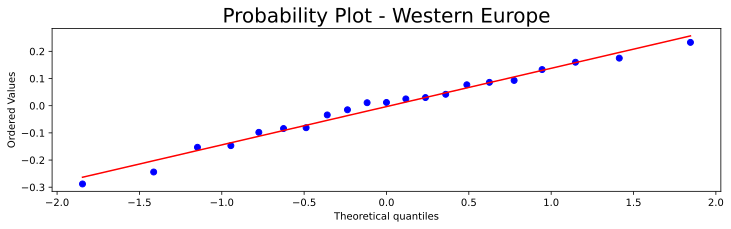

Sub-Saharan Africa variance = 0.02


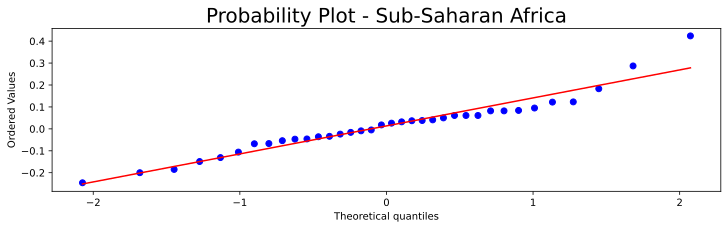

Southeast Asia variance = 0.06


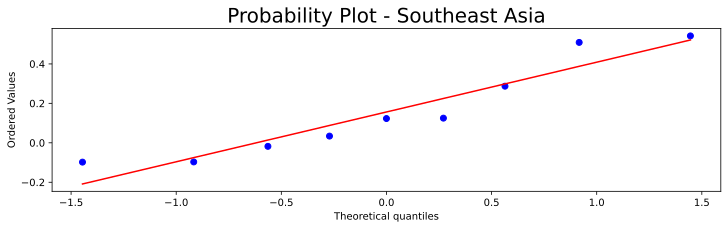

East Asia variance = 0.02


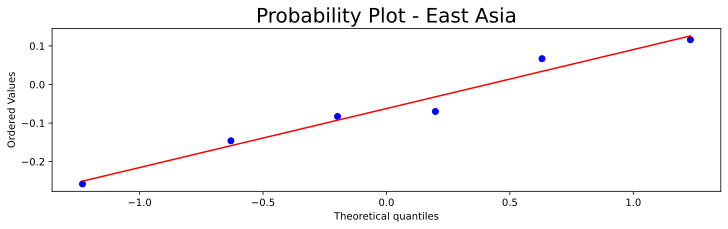

In [42]:
data_list = []
for region in regions:
    data_list.append(df.loc[(df['Regional indicator']==region)&(df['Year']==2021), 'Generosity'])
    data = df.loc[(df['Regional indicator']==region)&(df['Year']==2021), 'Generosity']
    print(f'{region} variance = {np.var(data, ddof=1):.2f}')
    fig = plt.figure(figsize=[12, 3], dpi=100)
    probplot(data, dist="norm", plot=plt)
    plt.title(f"Probability Plot - {region}", size=20)
    plt.show()

Все значения нормально распределены. Теперь проверим однородность дисперсий:  
    
**Гипотеза** 
* $H_0$: $\sigma_1^2 = \sigma_2^2 = \sigma_3^2 = \sigma_4^2 = \sigma_5^2 = \sigma_6^2 = \sigma_7^2 = \sigma_8^2 = \sigma_9^2 = \sigma_{10}^2$ 
* $H_1$: $\sigma_1^2 \neq \sigma_2^2 \neq \sigma_3^2 \neq \sigma_4^2 \neq \sigma_5^2 \neq \sigma_6^2 \neq \sigma_7^2 \neq \sigma_8^2 \neq \sigma_9^2 \neq \sigma_{10}^2$
* Критерий: тест Левена
* Уровень значимости $\normalsize \alpha$: 0.05

In [43]:
levene(*tuple(data_list))

LeveneResult(statistic=1.3364436819667922, pvalue=0.22350899865655754)

Так как p-value выше уровня значимости, принимаем первую гипотезу о том, что дисперсии однородны. Теперь можно провести дисперсионный анализ, чтобы увидеть, есть ли статистически значимые различия Generosity в разных регионах

In [44]:
south_asia = df.loc[(df['Regional indicator']=='South Asia')&(df['Year']==2021), 'Generosity']
central_eastern_europe = df.loc[(df['Regional indicator']=='Central and Eastern Europe')&(df['Year']==2021), 'Generosity']
africa_1 = df.loc[(df['Regional indicator']=='Middle East and North Africa')&(df['Year']==2021), 'Generosity']
africa_2 = df.loc[(df['Regional indicator']=='Sub-Saharan Africa')&(df['Year']==2021), 'Generosity']
latinos = df.loc[(df['Regional indicator']=='Latin America and Caribbean')&(df['Year']==2021), 'Generosity']
cis = df.loc[(df['Regional indicator']=='Commonwealth of Independent States')&(df['Year']==2021), 'Generosity']
america = df.loc[(df['Regional indicator']=='North America and ANZ')&(df['Year']==2021), 'Generosity']
western_europe = df.loc[(df['Regional indicator']=='Western Europe')&(df['Year']==2021), 'Generosity']
southeast_asia = df.loc[(df['Regional indicator']=='Southeast Asia')&(df['Year']==2021), 'Generosity']
east_asia = df.loc[(df['Regional indicator']=='East Asia')&(df['Year']==2021), 'Generosity']

**Гипотеза** 


* $H_0$: $\mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5 = \mu_6 = \mu_7 = \mu_8 = \mu_9 = \mu_{10}$ 
* $H_1$: $\mu_1 \neq \mu_2 \neq \mu_3 \neq \mu_4 \neq \mu_5 \neq \mu_6 \neq \mu_7 \neq \mu_8 \neq \mu_9 \neq \mu_{10}$
* Критерий: критерий Фишера
* Уровень значимости $\normalsize \alpha$: 0.05

In [45]:
f_oneway(south_asia, central_eastern_europe, africa_1, africa_2, latinos, cis, 
         america, western_europe, southeast_asia, east_asia)

F_onewayResult(statistic=3.410069207069039, pvalue=0.0008134473412183906)

Так как p-value меньше уровня значимости, мы отвергаем нулевую гипотезу в пользу альтернативной. Соответственно, значения Generosity в зависимости от региона отличаются.